### Imports

In [1]:
import scipy
import math
import pandas as pd
import numpy as np
import seaborn as sns 
import statsbombpy as sb
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
passesDF= pd.read_parquet('../Data/passes.parquet')
carriesDF= pd.read_parquet('../Data/carrys.parquet')
itcDF= pd.read_parquet('../Data/inteceptions.parquet')
dribblesDF= pd.read_parquet('../Data/dribbles.parquet')
pressuresDF= pd.read_parquet('../Data/pressures.parquet')
shotsDF= pd.read_parquet('../Data/shots.parquet')

## Players aggregated stats  
### Passes

1. Progressive Passes

In [3]:
# Progressive passes - passes made under pressure - completed passes made under pressure - passes under pressure comletion rate
# Goal coordinates    
goal_X= 120
goal_Y= 40

# Add starting location coordinates
passesDF[['X', 'Y']] = pd.DataFrame(passesDF['location'].to_list(), index= passesDF.index)

# Add end location coordinates
passesDF[['end_X', 'end_Y']]= pd.DataFrame(passesDF['pass_end_location'].to_list(), index= passesDF.index)

# add the distance between starting point and the goal (progressie passes calculation):
passesDF['start_distance']= np.sqrt((goal_X - passesDF.X)**2 + (goal_Y - passesDF.Y)**2)
passesDF['end_distance']= np.sqrt((goal_X - passesDF.end_X)**2 + (goal_Y - passesDF.end_Y)**2)

# check if a pass is progressive or not
passesDF['isProgressive'] = ((abs(passesDF['start_distance'] - passesDF['end_distance']) >= 0.25 * passesDF['start_distance']) & 
                             (abs(passesDF['Y'] - passesDF['end_Y']) >= 5)).tolist()

progressive_passes_DF = passesDF.groupby(["player_id", "player"])["isProgressive"].sum().reset_index()
progressive_passes_DF.rename(columns= {'isProgressive':'Progressive passes'}, inplace= True )
progressive_passes_DF.head()

,player_id,player,Progressive passes
0,2941,Ismaïla Sarr,22
1,2954,Youri Tielemans,10
2,2972,Marcus Thuram,4
3,2988,Memphis Depay,23
4,2989,Alexander Djiku,4


2. Total number of passes made under pressure, total number of completed passes made under pressure, and completion rate

In [4]:
passesDF['pass_outcome'] = passesDF['pass_outcome'].fillna(True)
passesDF= passesDF.loc[passesDF['under_pressure']== True]
# total number of passes played under pressure by player
pass_count = passesDF.groupby('player_id')['pass_outcome'].count().reset_index()
pass_count.rename(columns= {'pass_outcome': 'Passes'}, inplace=True)

# Total of successful passes played under presures
succ_passes= passesDF.loc[~(passesDF.pass_outcome.isin(['Incomplete', 'Unknown', 'Pass Offside','Out', 'Injury Clearance']))]
succ_passes_count= succ_passes.groupby('player_id')['pass_outcome'].count().reset_index()
succ_passes_count.rename(columns= {'pass_outcome': 'Passes completed'}, inplace=True)

merged_passes = succ_passes_count.merge(pass_count, on='player_id', how='left')
merged_passes['Passing completion rate']= round((merged_passes['Passes completed']/ merged_passes['Passes']) * 100, 2)
merged_passes.head()

,player_id,Passes completed,Passes,Passing completion rate
0,2941,12,20,60.00
1,2954,6,7,85.71
2,2972,10,17,58.82
3,2988,17,27,62.96
4,2995,20,24,83.33


In [5]:
# merge passes data
passesDF= merged_passes.merge(progressive_passes_DF, on= 'player_id', how= 'left')
passesDF.head()

,player_id,Passes completed,Passes,Passing completion rate,player,Progressive passes
0,2941,12,20,60.00,Ismaïla Sarr,22
1,2954,6,7,85.71,Youri Tielemans,10
2,2972,10,17,58.82,Marcus Thuram,4
3,2988,17,27,62.96,Memphis Depay,23
4,2995,20,24,83.33,Ángel Fabián Di María Hernández,51


## Carries

In [6]:
# Goal coordinates    
goal_X= 120
goal_Y= 40

# Add starting location coordinates
carriesDF[['X', 'Y']] = pd.DataFrame(carriesDF['location'].to_list(), index= carriesDF.index)

# Add end location coordinates
carriesDF[['end_X', 'end_Y']]= pd.DataFrame(carriesDF['carry_end_location'].to_list(), index= carriesDF.index)

# add the distance between starting point and the goal (progressie passes calculation):
carriesDF['start_distance']= np.sqrt((goal_X - carriesDF.X)**2 + (goal_Y - carriesDF.Y)**2)
carriesDF['end_distance']= np.sqrt((goal_X - carriesDF.end_X)**2 + (goal_Y - carriesDF.end_Y)**2)

# check if a pass is progressive or not
carriesDF['isProgressive'] = ((abs(carriesDF['start_distance'] - carriesDF['end_distance']) >= 0.25 * carriesDF['start_distance']) & 
                             (abs(carriesDF['Y'] - carriesDF['end_Y']) >= 5)).tolist()

carriesDF = carriesDF.groupby("player_id")["isProgressive"].sum().reset_index()
carriesDF.rename(columns= {'isProgressive':'Progressive carries'}, inplace= True )
carriesDF.head()

,player_id,Progressive carries
0,2941,13
1,2954,0
2,2972,6
3,2988,8
4,2989,1


### Pressures and succesful dribbles

In [7]:
# Pressures
pressuresDF= pressuresDF.groupby('player_id')['type'].count().reset_index()
pressuresDF.rename(columns={'type': 'Pressures'}, inplace= True)
pressuresDF.head()

,player_id,Pressures
0,2941,50
1,2954,15
2,2972,30
3,2988,45
4,2989,5


In [8]:
# Succesful Dribbles
dribblesDF= dribblesDF.loc[dribblesDF['dribble_outcome']== 'Complete']
dribblesDF= dribblesDF.groupby('player_id')['dribble_outcome'].count().reset_index()
dribblesDF.rename(columns={'dribble_outcome': 'Completed dribbles'}, inplace= True)
dribblesDF.head()

,player_id,Completed dribbles
0,2941,9
1,2954,1
2,2972,4
3,2988,3
4,2989,1


### Non-penalty xG, number of shots taken, xG per shot

In [9]:
# shot_statsbomb_xg
xgDF= shotsDF.groupby('player_id')['shot_statsbomb_xg'].sum().reset_index()

# Number of shots taken 
num_shotsDF= shotsDF.groupby('player_id')['type'].count().reset_index()

# merge DFs on player_id & rename columns
shotsDF= xgDF.merge(num_shotsDF, on= 'player_id', how= 'left')
shotsDF.rename(columns= {'shot_statsbomb_xg': 'xG', 'type': 'number of shots'}, inplace= True)

# then xG/shot
shotsDF['xG']=  round(shotsDF['xG'], 2)
shotsDF['xG/Shot']= round(shotsDF['xG']/ shotsDF['number of shots'], 2)
shotsDF.head()

,player_id,xG,number of shots,xG/Shot
0,2941,1.85,10,0.18
1,2972,0.12,1,0.12
2,2988,1.18,10,0.12
3,2995,0.53,7,0.08
4,3009,5.02,32,0.16


 ### Merge all dataframes

<AxesSubplot:>

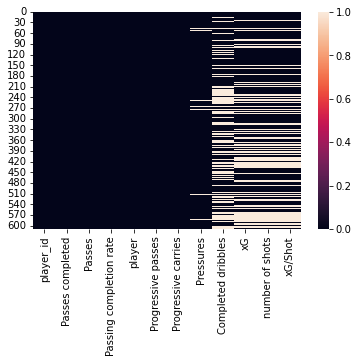

In [10]:
# Merge all columns
DF= passesDF.merge(carriesDF, on= 'player_id', how='outer')
DF= DF.merge(pressuresDF, on='player_id', how='outer')
DF= DF.merge(dribblesDF, on= 'player_id', how= 'outer')
DF= DF.merge(shotsDF, on= 'player_id', how='outer')

# Drop rows when player column is Nan
DF.dropna(subset='player', inplace= True)

# heatmap for missing values discovry
sns.heatmap(DF.isna())

NAN values in other columns just indicate that the player did not perform such event, thus we'll replace them with Zeros

In [11]:
# Fill Nan values with 0s
DF.fillna(0, inplace= True)

# change order of clumns
DF= DF.reindex(columns=['player_id', 'player', 'Passes completed', 'Passes', 'Passing completion rate',
                   'Progressive passes', 'Progressive carries', 'Pressures', 'Completed dribbles',
                   'xG', 'number of shots', 'xG/Shot'])

DF.head()

,player_id,player,Passes completed,Passes,Passing completion rate,Progressive passes,Progressive carries,Pressures,Completed dribbles,xG,number of shots,xG/Shot
0,2941,Ismaïla Sarr,12.0,20.0,60.00,22.0,13.0,50.0,9.0,1.85,10.0,0.18
1,2954,Youri Tielemans,6.0,7.0,85.71,10.0,0.0,15.0,1.0,0.00,0.0,0.00
2,2972,Marcus Thuram,10.0,17.0,58.82,4.0,6.0,30.0,4.0,0.12,1.0,0.12
3,2988,Memphis Depay,17.0,27.0,62.96,23.0,8.0,45.0,3.0,1.18,10.0,0.12
4,2995,Ángel Fabián Di María Hernández,20.0,24.0,83.33,51.0,24.0,34.0,18.0,0.53,7.0,0.08


## Player profile: Azzedine Ounahi

##### 1. Horizontal bars plot 

In [12]:
DF_= DF.drop(['number of shots'], axis= 1)
values= DF_.loc[DF_['player']== 'Azzedine Ounahi'].values.tolist()[0][2:]
metrics= DF_.columns.values.tolist()[2:]
percentiles = []

for x in range(len(metrics)):
    percentiles.append(math.floor(scipy.stats.percentileofscore(DF_[metrics[x]], values[x])))

# Azzedine ounahi's percentiles data
percentiles

[97, 97, 51, 65, 91, 97, 98, 67, 49]

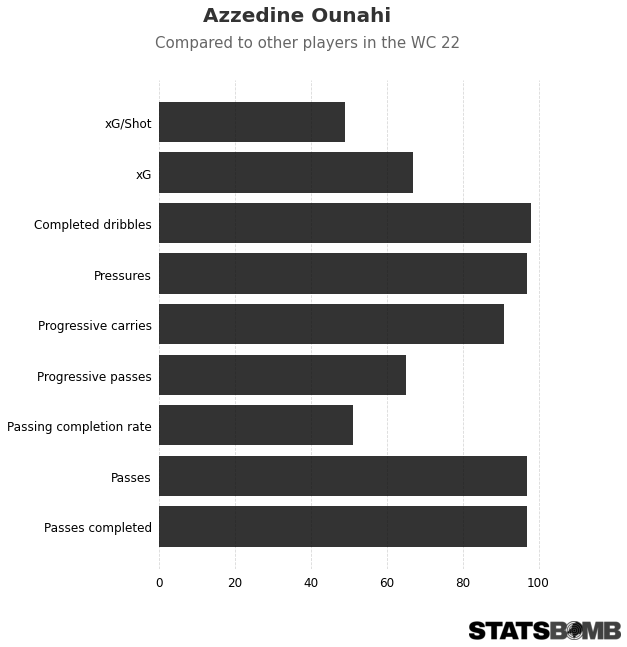

In [13]:
# Set the figure 
fig, ax= plt.subplots()
fig.set_size_inches(7, 9)
fig.set_facecolor('white')
labels= metrics

# Horizontal bars plot
ax.barh(labels, percentiles, align='center', color= 'black', alpha=.8, zorder= 2)
ax.grid(axis='x', alpha=.5, linestyle='--', zorder= 1)

# Set ticks visibility to false
ax.tick_params(tick1On=False, labelsize=12)

# set spines visibility to false 
ax.spines.left.set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)

# Set titles 
title= 'Azzedine Ounahi'
subtitle= 'Compared to other players in the WC 22'
fig.text(.4, .97, title, fontsize=20, fontweight= 'bold', ha= 'center', color='black', alpha=.8)
fig.text(.42, .93, subtitle, fontsize=15, ha= 'center', color='black', alpha=.6)

# Add Statsbomb image 
img_dir= "C:/Users/pc/Desktop/statsbomb.png"    
ax= fig.add_axes([.74, -0.07, 0.3, 0.2])
ax.axis("off")
img = Image.open(img_dir)
ax.imshow(img)

##### 2. Distribution plot 

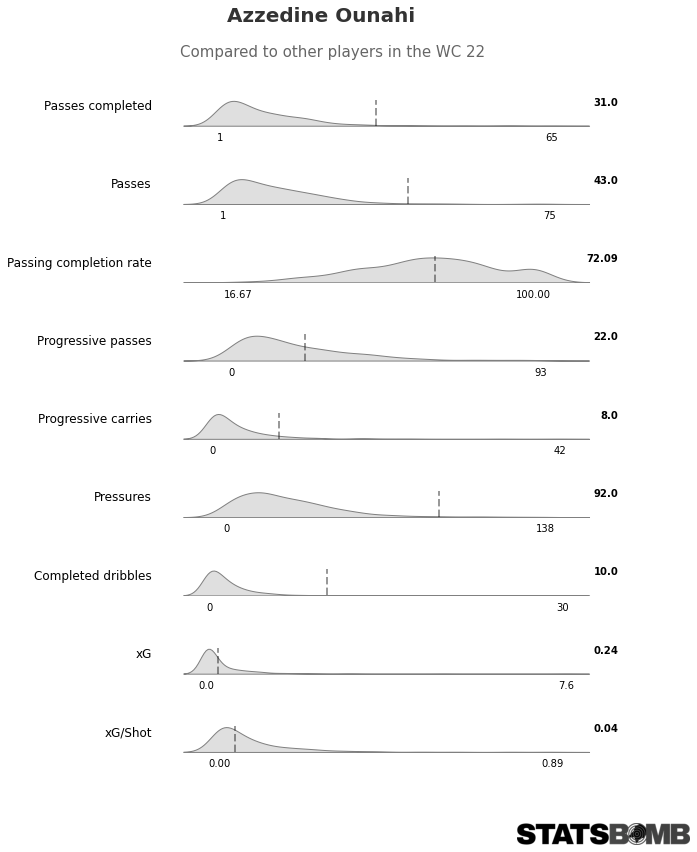

In [14]:
fig, ax= plt.subplots(9, 1)
fig.set_size_inches(8, 12)
fig.set_facecolor('white')
plt.subplots_adjust(hspace= 2)

# show the plot

# make the distribution plots 
for i in range(len(ax)):
    
    ax[i].tick_params(tick1On=False)
    ax[i].axes.yaxis.set_ticklabels([])
    ax[i].spines.left.set_visible(False)
    ax[i].spines.right.set_visible(False)
    ax[i].spines.top.set_visible(False)
    ax[i].spines.bottom.set_visible(False)
    ax[i].patch.set_alpha(0)
    
    sns.kdeplot(DF_[metrics[i]],color='grey',shade=True, ax= ax[i])
    ax[i].axvline(x= values[i], color='black', alpha= .4, ls='--', lw=2)
    ax[i].text(1.02, 0.9, values[i], ha='right', va='center', fontweight= 'bold', transform=ax[i].transAxes)

    ax[i].set_xticks([DF_[metrics[i]].min(), DF_[metrics[i]].max()])
    ax[i].set_xlabel('')
    ax[i].set_ylabel(labels[i], fontsize= 12)
    ax[i].yaxis.get_label().set_rotation(0)
    ax[i].yaxis.get_label().set_ha('right')

title= 'Azzedine Ounahi'
subtitle= 'Compared to other players in the WC 22'
fig.text(.4, .97, title, fontsize=20, fontweight= 'bold', ha= 'center', color='black', alpha=.8)
fig.text(.42, .93, subtitle, fontsize=15, ha= 'center', color='black', alpha=.6)

# Add Statsbomb image 
img_dir= "C:/Users/pc/Desktop/statsbomb.png"    
ax= fig.add_axes([.74, -0.07, 0.3, 0.2])
ax.axis("off")
img = Image.open(img_dir)
ax.imshow(img)

##### 3. Put it all together

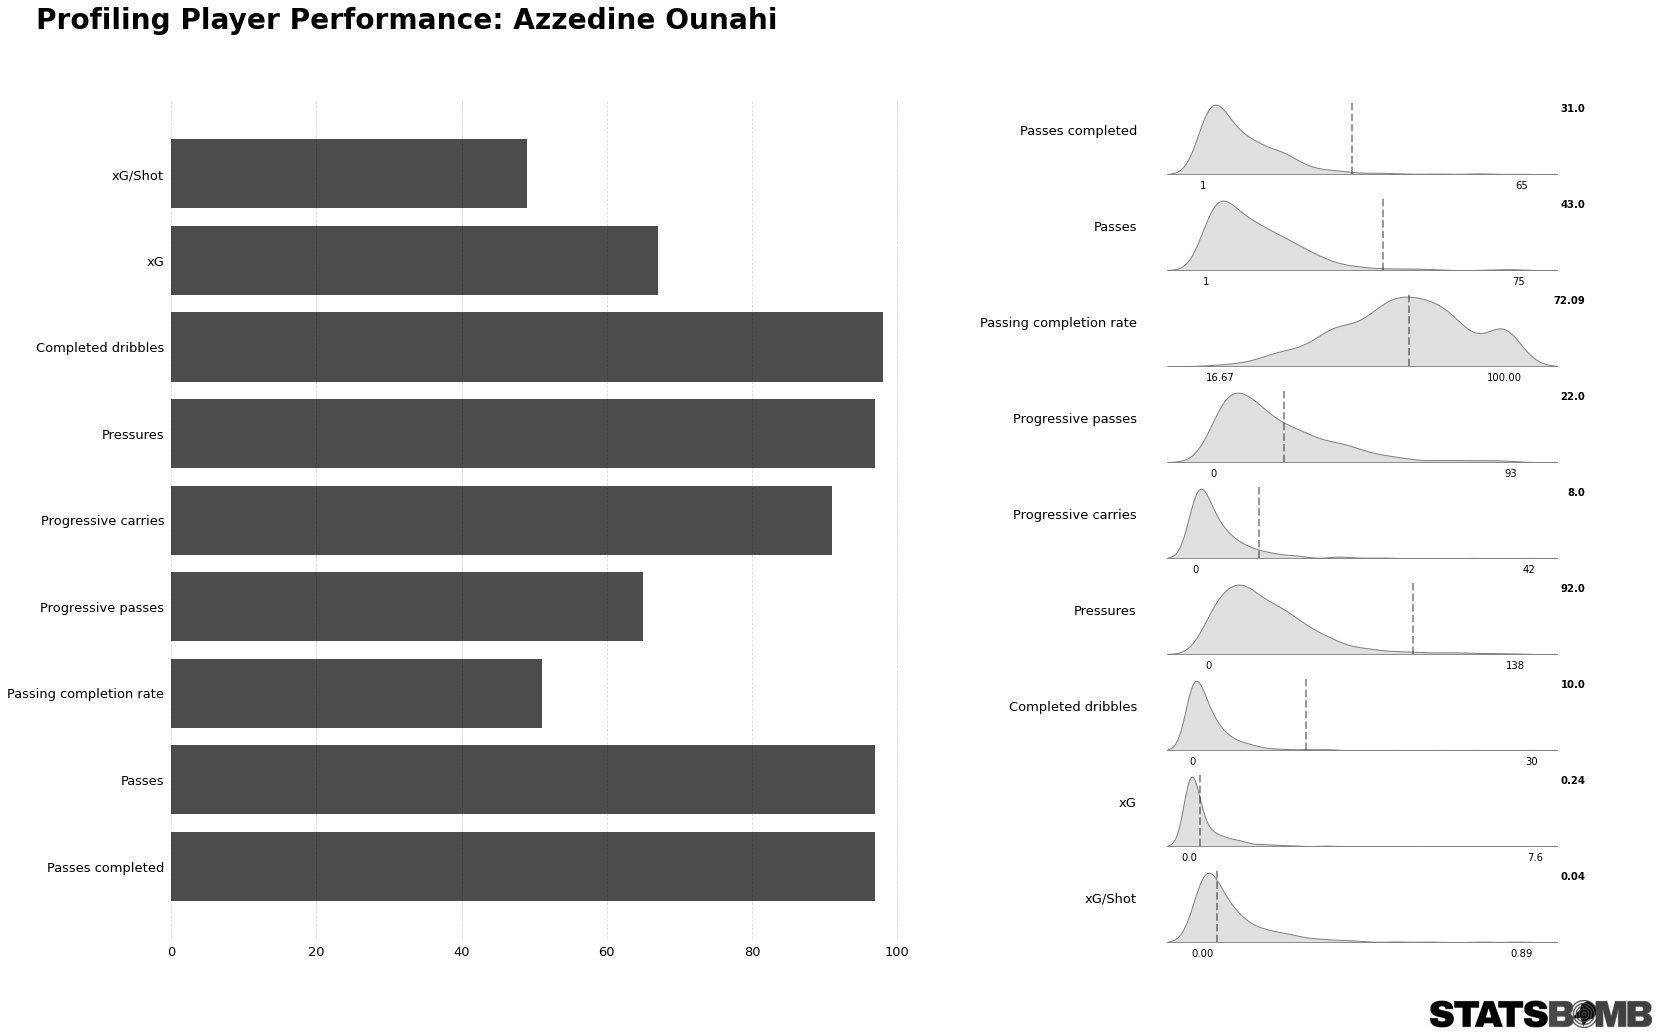

In [15]:
# Set the figure 
fig = plt.figure(layout="constrained")
fig.set_size_inches(22, 12)
fig.set_facecolor('white')

# Set the distribution of axis (9 for players distibution metrics/ 1 for the percntiles rankings)
subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[1.5, 1.])
axs0 = subfigs[0].subplots(1, 1)

axs0.barh(labels, percentiles, align='center', color= 'black', alpha=.7, zorder= 2)
axs0.grid(axis='x', alpha=.5, linestyle='--', zorder= 1)


# Set ticks visibility to false
axs0.tick_params(tick1On=False, labelsize=13)

# set spines visibility to false 
axs0.spines.left.set_visible(False)
axs0.spines.right.set_visible(False)
axs0.spines.top.set_visible(False)
axs0.spines.bottom.set_visible(False)

axs1 = subfigs[1].subplots(9, 1)

for i in range(len(axs1)):
    
    axs1[i].tick_params(tick1On=False)
    axs1[i].axes.yaxis.set_ticklabels([])
    axs1[i].spines.left.set_visible(False)
    axs1[i].spines.right.set_visible(False)
    axs1[i].spines.top.set_visible(False)
    axs1[i].spines.bottom.set_visible(False)
    axs1[i].patch.set_alpha(0)
    
    sns.kdeplot(DF_[metrics[i]],color='grey',shade=True, ax= axs1[i])
    axs1[i].axvline(x= values[i], color='black', alpha= .4, ls='--', lw=2)
    axs1[i].text(1.02, 0.9, values[i], ha='right', va='center', fontweight= 'bold', transform=axs1[i].transAxes)

    axs1[i].set_xticks([DF_[metrics[i]].min(), DF_[metrics[i]].max()])
    axs1[i].set_xlabel('')
    axs1[i].set_ylabel(labels[i], fontsize= 13)
    axs1[i].yaxis.get_label().set_rotation(0)
    axs1[i].yaxis.get_label().set_ha('right')
    
# Add the title and subtitle
title_text= "Profiling Player Performance: Azzedine Ounahi"
fig.text(0.02, 1.08, title_text, fontsize=28, fontweight= 'bold', color='black')

# Add Statsbomb image 
img_dir= "C:/Users/pc/Desktop/statsbomb.png"    
ax= fig.add_axes([.9, -0.13, 0.14, 0.14])
ax.axis("off")
img = Image.open(img_dir)
ax.imshow(img)

In [ ]:
Player radar